Before starting, the most confusing part about writing this (not "most-most" but quite confusing) was the choice between using keras and tensorflow. My first thought was that keras was tensorflows backend since it's a subpackage in tf i.e tf.keras. Since I heard about keras and used it since I thought it would be best to learn some of the backend but that was not the case.

Tensorflow is the default backend for keras, since keras works as a ML API, but tensorflow and keras has grown together so when learning tensorflow one implicitly learns keras.

In [1]:
import tensorflow as tf
import tensorflow.keras as K #don't realy like this reference but are commonly used
import numpy as np

Tensorflow uses as expected tensors, the differs from numpy tensors by 2 things.

1. They can be accelerated in the GPU/TPU.
2. They are immutable, i.e can't be "changed". only create a new one.

So let's study a tensor and define a 2x2 matrix, both from tensorflow but also as numpy/python

In [6]:
m1 = [[1.0, 2.0], 
      [3.0, 4.0]]

m2 = np.array([[1.0, 2.0], 
               [3.0, 4.0]], dtype=np.float32)

m3 = tf.constant([[1.0, 2.0], 
                  [3.0, 4.0]])

print(type(m1))
print(type(m2))
print(type(m3))

<class 'list'>
<class 'numpy.ndarray'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [7]:
print(m3)

tf.Tensor(
[[1. 2.]
 [3. 4.]], shape=(2, 2), dtype=float32)


A tf tensor has a shape and datatype and can easily be casted to a numpy array. The axes of the shape are usually ordered from global to local. (This way features vectors are contiguous in the memory) 

![title](Pictures/test.png)

In [10]:
print(type(m3.numpy()))
print(m3)

<class 'numpy.ndarray'>
tf.Tensor(
[[1. 2.]
 [3. 4.]], shape=(2, 2), dtype=float32)


We can also go the other way by

In [11]:
print(tf.constant(m2))

tf.Tensor(
[[1. 2.]
 [3. 4.]], shape=(2, 2), dtype=float32)


In [12]:
x = 1
y = 2
print(x+y)

3


As expected let's see how tensorflow does this

In [13]:
tfx = tf.constant(1)
tfy = tf.constant(2)
print(tfx+tfy)

tf.Tensor(3, shape=(), dtype=int32)


Just as with numpy it uses operator overloading, i.e element-wise operation or (@-matrix multiplication) 

Tensorflow also are able to represent ragged tensor and sparse tensors.

In [14]:
ragged_list = [
    [0, 1, 2, 3],
    [4, 5],
    [6, 7, 8],
    [9]]

ragged_tensor = tf.ragged.constant(ragged_list)
print(ragged_tensor)
print(ragged_tensor.appendshape)

<tf.RaggedTensor [[0, 1, 2, 3], [4, 5], [6, 7, 8], [9]]>


In [15]:
sparse_tensor = tf.sparse.SparseTensor(indices=[[0, 0], [1, 2]],
                                       values=[1, 2],
                                       dense_shape=[3, 4])
print(sparse_tensor)

SparseTensor(indices=tf.Tensor(
[[0 0]
 [1 2]], shape=(2, 2), dtype=int64), values=tf.Tensor([1 2], shape=(2,), dtype=int32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


We have studied some constant tensors, that cannot change its value, so what happends if we want it to dynamically change something, or let it depend on something else (i.e a variable). The answer is tf.Variable

In [30]:
tf_variable = tf.Variable(np.array([[1,2],[3,4]]))
print(tf_variable)

print(tf.argmax(tf_variable))

<tf.Variable 'Variable:0' shape=(2, 2) dtype=int32, numpy=
array([[1, 2],
       [3, 4]])>
tf.Tensor([1 1], shape=(2,), dtype=int64)


In [31]:
tf_variable.assign([[4,3],[2,1]])

<tf.Variable 'UnreadVariable' shape=(2, 2) dtype=int32, numpy=
array([[4, 3],
       [2, 1]])>

tf.Variable instance have the same lifecycle as other Python objects. When there are no references to a variable it is automatically deallocated, Variables can also be named which can help you track and debug them.

In [33]:
a = tf.Variable(np.array([1,2]), name="1-D")
print(a)

<tf.Variable '1-D:0' shape=(2,) dtype=int32, numpy=array([1, 2])>


Tensorflow automatically choses where the tensors will be places. We can explicitly define them like

In [36]:
with tf.device('CPU:0'):

  # Create some tensors
  a = tf.Variable([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
  c = tf.matmul(a, b)

print(c)

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


They are well behave and can be used over processor, but will cause an delay since it has to copy.

In [37]:
with tf.device('CPU:0'):
  a = tf.Variable([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tf.Variable([[1.0, 2.0, 3.0]])

with tf.device('GPU:0'):
  # Element-wise multiply
  k = a * b

print(k)

tf.Tensor(
[[ 1.  4.  9.]
 [ 4. 10. 18.]], shape=(2, 3), dtype=float32)


Tensorflow 2.0 presented eager execution, that has been up to now used freely. Before one had to define a Session and functions to be able to calculate the $a*b$ as above. More importantly it "replaces" the graph/session mode, that still exist, that was used to export it to different language and machine. Tensorflow 1.x graph has good distibuted training, performance optimzation, to bride the gap tensorflow implemented tf.function, which we will look at later.

With that said, eager execution suits us good for now. With eager execution, eager training comes. We can use tf.GradientTape to trace operation for upcoming gradients, this uses the famous automatic differentiation, which is besicaly chain rule on steroids.

This gradient tape "records" all the forward pass operation and plays the record backwards then discard it after the call.

In [43]:
w = tf.Variable([[1.0]])
with tf.GradientTape() as tape:
  forward = w ** 2

grad = tape.gradient(forward, w)
print(grad)

tf.Tensor([[2.]], shape=(1, 1), dtype=float32)


It wouldn't (it would) be a gradient if it only could differentiate w.r.p one variable.

In [44]:
w = tf.Variable(tf.random.normal((3, 2)), name='w')
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name='b')
x = [[1., 2., 3.]]

with tf.GradientTape(persistent=True) as tape:
  y = x @ w + b
  loss = tf.reduce_mean(y**2)

[dl_dw, dl_db] = tape.gradient(loss, [w,b])
print(dl_dw)  

tf.Tensor(
[[ 1.1533583 -0.6595056]
 [ 2.3067167 -1.3190112]
 [ 3.460075  -1.9785168]], shape=(3, 2), dtype=float32)


Not everything will be auto differentiated, we need to have a variable to be able to derivate it. 

In [97]:

x0 = tf.Variable(3.0, name='x0') # Only one who will be watched from the point of the tape.

x1 = tf.Variable(3.0, name='x1', trainable=False)

x2 = tf.Variable(2.0, name='x2') + 1.0

x3 = tf.constant(3.0, name='x3')

with tf.GradientTape() as tape:
  y = (x0**2) + (x1**2) + (x2**2)

grad = tape.gradient(y, [x0, x1, x2, x3])

for g in grad:
  print(g)

[var.name for var in tape.watched_variables()]

tf.Tensor(6.0, shape=(), dtype=float32)
None
None
None


['x0:0']

In [99]:
x = tf.constant(3.0)
with tf.GradientTape() as tape:
  tape.watch(x)
  y = x**2

# dy = 2x * dx
dy_dx = tape.gradient(y, x)
print(dy_dx.numpy())

6.0


Sometime one want to treat something as differentiable, we can use tape.watch() function to request the gradient of the intermidiate value. We can also control the flow, with usual python operation and also force the tape to compute gradients over the same computation i.e not throw it away when used (as it usually does).

In [102]:
x = tf.constant(1.0)

v0 = tf.Variable(2.0)
v1 = tf.Variable(2.0)

with tf.GradientTape(persistent=True) as tape:
  tape.watch(x)
  if x > 0.0:
    result = v0
  else:
    result = v1**2 

dv0, dv1 = tape.gradient(result, [v0, v1])

print(dv0)
print(dv1)

del tape  # Drop the reference to the tape

tf.Tensor(1.0, shape=(), dtype=float32)
None


Gradient can sometime be None, and be hard to debug. Often when a target is not connected i.e df_dx = None when there is no x in f. A tricky problem is when we are not using assing on the variable or when we did calculation outside of tensorflow.

In [104]:
#1. Replaced a variable with a tensor.

x = tf.Variable(2.0)

for epoch in range(2):
  with tf.GradientTape() as tape:
    y = x+1

  print(tape.gradient(y, x))
  x = x + 1   # This should be `x.assign_add(1)`

tf.Tensor(1.0, shape=(), dtype=float32)
None


In [105]:
#2. Did calculations outside of TensorFlow
x = tf.Variable([[1.0, 2.0],
                 [3.0, 4.0]], dtype=tf.float32)

with tf.GradientTape() as tape:
  x2 = x**2

  # This step is calculated with NumPy
  y = np.mean(x2, axis=0)

  # Like most ops, reduce_mean will cast the NumPy array to a constant tensor
  # using `tf.convert_to_tensor`.
  y = tf.reduce_mean(y, axis=0)

print(tape.gradient(y, x))

None


In [106]:
#3. Did gradient not on a float

# The x0 variable has an `int` dtype.
x = tf.Variable([[2, 2],
                 [2, 2]])

with tf.GradientTape() as tape:
  # The path to x1 is blocked by the `int` dtype here.
  y = tf.cast(x, tf.float32)
  y = tf.reduce_sum(x)

print(tape.gradient(y, x))

None


In [107]:
#4. Took gradients through a stateful object, i.e variable has an internal state (the value), the gradient stop there i.e does not go back to x0

x0 = tf.Variable(3.0)
x1 = tf.Variable(0.0)

with tf.GradientTape() as tape:
  # Update x1 = x1 + x0.
  x1.assign_add(x0)
  # The tape starts recording from x1.
  y = x1**2   # y = (x1 + x0)**2

# This doesn't work.
print(tape.gradient(y, x0))   #dy/dx0 = 2*(x1 + x2)

None


We now now how to make variable and how to differentiate them. It's not that far from being able to do a ML model. We will go through the most used data set (do not quote me on that), we will use layers already defined but is besically some smart operation and layering on what we already seen (i.e variable and operations). We will also use a know optimizer and a loss function.

Let's download the MNIST handwritten digits. 

In [2]:
(mnist_images, mnist_labels), _ = K.datasets.mnist.load_data()

#Ignore this for now
dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32),
   tf.cast(mnist_labels,tf.int64)))


dataset = dataset.shuffle(1000).batch(32)

#Optimizer, and loss function (from keras)
optimizer = K.optimizers.Adam()
loss_object = K.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_history = []

Let's use a standard simple CNN

In [3]:
#Standard CNN (from keras) a bunch of layers stacked
mnist_model = K.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu',
                         input_shape=(None, None, 1)),
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])

Let's have the forward pass and record it in our train_step function.

In [4]:
def train_step(images, labels):
  with tf.GradientTape() as tape:
    logits = mnist_model(images, training=True)
    
    # Add asserts to check the shape of the output.
    tf.debugging.assert_equal(logits.shape, (32, 10))
    
    loss_value = loss_object(labels, logits)

  loss_history.append(loss_value.numpy().mean())
  grads = tape.gradient(loss_value, mnist_model.trainable_variables)
  optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables))

In [5]:
epochs = 3
for epoch in range(epochs):
    for (batch, (images, labels)) in enumerate(dataset):
      train_step(images, labels)
    print ('Epoch {} finished'.format(epoch))

tf.Tensor(2.3009412, shape=(), dtype=float32)
tf.Tensor(2.304256, shape=(), dtype=float32)
tf.Tensor(2.3018851, shape=(), dtype=float32)
tf.Tensor(2.3039572, shape=(), dtype=float32)
tf.Tensor(2.297106, shape=(), dtype=float32)
tf.Tensor(2.2997394, shape=(), dtype=float32)
tf.Tensor(2.3016849, shape=(), dtype=float32)
tf.Tensor(2.2918544, shape=(), dtype=float32)
tf.Tensor(2.3066485, shape=(), dtype=float32)
tf.Tensor(2.2943168, shape=(), dtype=float32)
tf.Tensor(2.304329, shape=(), dtype=float32)
tf.Tensor(2.3100405, shape=(), dtype=float32)
tf.Tensor(2.3035934, shape=(), dtype=float32)
tf.Tensor(2.2997718, shape=(), dtype=float32)
tf.Tensor(2.2972698, shape=(), dtype=float32)
tf.Tensor(2.2946794, shape=(), dtype=float32)
tf.Tensor(2.2999954, shape=(), dtype=float32)
tf.Tensor(2.2968154, shape=(), dtype=float32)
tf.Tensor(2.3022866, shape=(), dtype=float32)
tf.Tensor(2.2996316, shape=(), dtype=float32)
tf.Tensor(2.3058028, shape=(), dtype=float32)
tf.Tensor(2.30086, shape=(), dtype=fl

tf.Tensor(2.256456, shape=(), dtype=float32)
tf.Tensor(2.2728596, shape=(), dtype=float32)
tf.Tensor(2.2362113, shape=(), dtype=float32)
tf.Tensor(2.2322571, shape=(), dtype=float32)
tf.Tensor(2.2160006, shape=(), dtype=float32)
tf.Tensor(2.2324033, shape=(), dtype=float32)
tf.Tensor(2.1951957, shape=(), dtype=float32)
tf.Tensor(2.2076073, shape=(), dtype=float32)
tf.Tensor(2.2063093, shape=(), dtype=float32)
tf.Tensor(2.2162795, shape=(), dtype=float32)
tf.Tensor(2.1668935, shape=(), dtype=float32)
tf.Tensor(2.2461364, shape=(), dtype=float32)
tf.Tensor(2.2203891, shape=(), dtype=float32)
tf.Tensor(2.2203834, shape=(), dtype=float32)
tf.Tensor(2.2012486, shape=(), dtype=float32)
tf.Tensor(2.2096026, shape=(), dtype=float32)
tf.Tensor(2.196995, shape=(), dtype=float32)
tf.Tensor(2.2413652, shape=(), dtype=float32)
tf.Tensor(2.2204132, shape=(), dtype=float32)
tf.Tensor(2.255425, shape=(), dtype=float32)
tf.Tensor(2.190711, shape=(), dtype=float32)
tf.Tensor(2.1818318, shape=(), dtype=f

limit_output extension: Maximum message size of 10000 exceeded with 10191 characters

KeyboardInterrupt: 

Text(0, 0.5, 'Loss [entropy]')

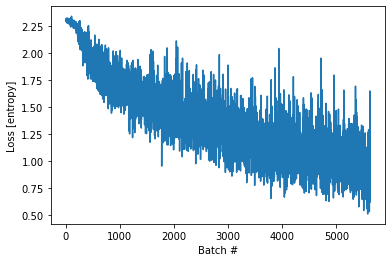

In [51]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

In [96]:
mnist_example = dataset.take(1)
for image,labels in mnist_example.as_numpy_iterator():
    p = tf.argmax(mnist_model.predict(image),axis=1)
    for i,w in enumerate(p):
        print(w==labels[i])

tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(False, shape=(), dtype=bool)
tf.Tensor(False, shape=(), dtype=bool)
tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(False, shape=(), dtype=bool)
tf.Tensor(False, shape=(), dtype=bool)
tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(False, shape=(), dtype=bool)
tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(False, shape=(), dtype=bool)
tf.Tensor(False, shape=(), dtype=bool)
tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(False, shape=(), dtype=bool)
tf.Tensor(True, shape=(), dtype=bool)
tf.T